## Handling User and Reading list (=Media list) data

#### ToDo

- [x] Favorites are not enough to describe user preferences -> get anime/manga list that the users' have experienced.
- [x] Convert "reading list" (= media list) to list-genre table to express which genre a user has experienced the most
- [x] Try similar approach with tag data
- [x] Average the summed flag values by media count per user -> probability of choosing a particular genre/tag -> StandardScaler -> Check how the distribution changes
- [x] Calculate user similarities
- [x] Be able to pick out a similar user and check for title discrepancies -> diff in titles will be the recommendation list
- [ ] Evaluation: average of title overlap ratio of top 10 similar users
    - [ ] cosine
    - [ ] euclidean
    - [ ] manhattan
- [ ] Try tags
    - [x] Just the tag probability -> No good. Most tags don't go over 0.1 or 0.2. 
    - [ ] PCA -> 20 n_components = 25% variance explained, sp pretty low -> it might work though?
- [ ] Recommendation
    - [ ] From those "unread" list, rank the highest matching title for the user
        - [ ] a) Pick the title with similar genre distribution to the user's genre distribution
        - [ ] b) Pick the most popular titles
        - [ ] c) From top 10 similar users, which title have you not seen/read but the others have?
    - [ ] From list that includes "read" list


#### Other
- [x] Refactor: separate sections for scaled & not scaled codes
- [ ] Extra: Convert media list to network visualization
- [ ] Weight the experienced media by its status (CURRENT/DROPPED etc)
- [ ] Try item-user matrix recommendation

Need to be able to see what kind of genre/type that the user lieks

In [ ]:
# !pip install sweetviz
# !pip install joypy

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot
import sweetviz as sv
from tqdm import tqdm
from collections import ChainMap
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
pd.set_option("max_columns", 200)

In [2]:
# Ridge plotting function to keep the code DRY
def plot_ridge(df, cols, by_col, x_axis_range, title):
    joyplot(
        data=df[cols],
        linewidth=0.5,
        x_range=x_axis_range,
        by=by_col,
        figsize=(10,8)
    )
    plt.title(title, fontsize=16)
    plt.show()

In [2]:
# Load data
df_titles = pd.read_csv("../assets/titles_2000p.csv")
df_tags = pd.read_csv("../assets/tags_2000p.csv")

In [3]:
print(df_titles.shape)
print(df_tags.shape)

(98927, 35)
(269425, 7)


## Data processing

### title:tags table. (Commented out to avoid running)

In [4]:
# id_romaji_match = df_titles[["title_id", "title_romaji"]]
# print(id_romaji_match.shape)

# # Convert tags table
# res = []

# for t_id in tqdm(df_tags["title_id"].unique()):
#     df = df_tags[df_tags["title_id"]==t_id]
#     tag_name_list = list(df["tag_name"].unique())
#     title_tags = dict()
#     title_tags[t_id] = str(tag_name_list)
#     res.append(title_tags)

# res_list = []
# for r in res:
#     for k,v in r.items():
#         res_list.append([k,v])

# df_title_tag = pd.DataFrame(res_list, columns=["title_id", "tag_name_array"])
# print(df_title_tag.shape)
# display(df_title_tag.head())

# df_title_tag_romaji = pd.merge(id_romaji_match, df_title_tag, how="inner", on="title_id")
# display(df_title_tag_romaji.head())
# print(df_title_tag_romaji.shape)

# # check id-romaji match
# display(df_titles[df_titles["title_id"]==103948])
# display(df_title_tag_romaji[df_title_tag_romaji["title_id"]==86018])

# # Convert tag_name_array columns to OHE-like columns
# df_title_tag_romaji["tag_name_array"] = df_title_tag_romaji["tag_name_array"].replace("['|\"|\[|\]]", "", regex=True)
# df_title_tag_romaji["tag_name_array"] = df_title_tag_romaji["tag_name_array"].apply(lambda x: x.split(","))
# display(df_title_tag_romaji[df_title_tag_romaji["title_id"]==86018])

# mlb = MultiLabelBinarizer()
# df_title_tag_romaji_ohe = df_title_tag_romaji.join(pd.DataFrame(mlb.fit_transform(df_title_tag_romaji["tag_name_array"]), columns=mlb.classes_))
# df_title_tag_romaji_ohe = df_title_tag_romaji_ohe.drop("tag_name_array", axis=1)
# display(df_title_tag_romaji_ohe.head(2))
# df_title_tag_romaji_ohe = df_title_tag_romaji_ohe.drop_duplicates()

# df_title_tag_romaji_ohe.to_csv("../assets/ryota_title_tags_2000p.csv", index=False)

### title:genre table. (Commented out to avoid running)

In [5]:
# # Preprocess genre column: convert from string to array
# df_titles["genres"] = df_titles["genres"].apply(lambda x: re.findall("'(.*?)'", x))

# # Convert genre columns to OHE-like columns
# mlb = MultiLabelBinarizer()
# df_titles = df_titles.join(pd.DataFrame(mlb.fit_transform(df_titles["genres"]),columns=mlb.classes_))
# df_titles = df_titles.drop("genres", axis=1)

# # Create titles_to_genre table for future use
# df_titles_idx = df_titles.set_index("title_id")
# df_titles_genre = df_titles_idx.iloc[:, 33:52].reset_index()
# display(df_titles_genre)
# df_titles_genre = df_titles_genre.drop_duplicates()

# df_titles_genre.to_csv("../assets/ryota_title_genre_2000p.csv", index=False)

### media_list:genre table (Commented out to avoid running)

In [6]:
# # Work with the titles that the users have read or are reading

# # First, concatenate the separated "media_list" files
# df_mlist_1 = pd.read_csv("../assets/media_list_2000_users.csv")
# df_mlist_2 = pd.read_csv("../assets/media_list_2001_5000_users.csv")
# df_mlist_3 = pd.read_csv("../assets/media_list_5001_10000_users.csv")
# df_mlist = pd.concat([df_mlist_1, df_mlist_2, df_mlist_3], axis=0)
# print("length of media lists before joining: ", len(df_mlist_1), len(df_mlist_2), len(df_mlist_3))
# print("length of concat media list dfs: ", len(df_mlist))

# # Save the concatenated df as csv
# df_mlist.to_csv("../assets/media_list_all_users.csv", index=False)

# # For every title that user chooses, convert it to title-genre to show their preference
# df_titles_genre = pd.read_csv("../assets/ryota_title_genre_2000p.csv")
# df_mlist_genre = df_mlist.join(df_titles_genre, how="left", on="title_id", rsuffix="_overlap")
# df_mlist_genre = df_mlist_genre.drop(columns=["title_id_overlap"])
# print("rows with no genre info: ", len(df_mlist_genre[df_mlist_genre.isna().any(axis=1)]))
# df_mlist_genre = df_mlist_genre.dropna(how="any")
# print("length after dropping NaNs: ", len(df_mlist_genre))

# # Aggregate genre counts per user
# res = []
# for u_id in tqdm(df_mlist_genre["user_id"].unique()):
#     df = df_mlist_genre[df_mlist_genre["user_id"]==u_id]
#     genre_counts = df.iloc[:, 5:].sum(axis=0).values
#     genre_count_row = np.insert(genre_counts, [0,0], [u_id, len(df)])
#     res.append(genre_count_row)

# cols = ["user_id", "mlist_count"]
# tag_cols = list(df_mlist_genre.iloc[:, 5:].columns)
# df_mlist_genre = pd.DataFrame(res, columns=cols+tag_cols)
# display(df_mlist_genre)

# # convert float columns to ints
# for col in df_mlist_genre.columns:
#     if df_mlist_genre[col].dtype == np.float:
#         df_mlist_genre[col] = df_mlist_genre[col].astype(int)

# # Save medialist-genre df as csv
# df_mlist_genre.to_csv("../assets/ryota_media_list_genre.csv", index=False)


### with media_list:tags table. Simple df.join causes MEMORY ERROR so iterate over user_id and title_id

In [7]:
# # Work with the titles that the users have read or are reading

# # Load concat "media_list"
# df_mlist = pd.read_csv("../assets/media_list_all_users.csv")
# print("length of concat media list dfs: ", len(df_mlist))

# # For every title that user chooses, convert it to title-tags to show their preference
# df_titles_tags = pd.read_csv("../assets/ryota_title_tags_2000p.csv")

# print(df_mlist.shape)
# print(df_titles_tags.shape)

# # df.join like mlist-genre doesn't work as it causes MEMORY ERROR.
# # so iterate over user_id and title_id instead
# res = []
# for u_id in tqdm(df_mlist["user_id"].unique()):
#     user_row = []
#     df = df_mlist[df_mlist["user_id"]==u_id]
#     for t_id in df["title_id"].unique():
#         try:
#             df_tags = df_titles_tags[df_titles_tags["title_id"]==t_id]
#             tag_flags = df_tags.values[0][2:]
#             user_row.append(tag_flags)
#         except:
#             pass
#             # print("error at: ", u_id, t_id)
#     sum_row = sum(user_row)
#     sum_row = np.insert(sum_row, [0,0], [u_id, len(user_row)])
#     res.append(sum_row)

# cols = ["user_id", "mlist_count"]
# tag_cols = list(df_titles_tags.iloc[:, 2:].columns)
# df_mlist_tags = pd.DataFrame(res, columns=cols+tag_cols)

# # print("rows with no tag info: ", len(df_mlist_tags[df_mlist_tags.isna().any(axis=1)]))
# # df_mlist_tags = df_mlist_tags.dropna(how="any")
# # print("length after dropping NaNs: ", len(df_mlist_tags))

# # convert to ints
# for col in df_mlist_tags.columns:
#     if df_mlist_tags[col].dtype == np.float:
#         df_mlist_tags[col] = df_mlist_tags[col].astype(int)

# # Save medialist-genre df as csv
# df_mlist_tags.to_csv("../assets/ryota_media_list_tags.csv", index=False)

## Calculating user similarities

In [96]:
df_media_list_genre = pd.read_csv("../assets/ryota_media_list_genre.csv")
display(df_media_list_genre.head(2))

,user_id,mlist_count,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,361,89,65,133,100,36,88,37,9,9,11,12,25,18,129,30,60,14,42,3
1,2,287,76,49,120,89,22,76,21,11,6,9,6,20,21,114,30,62,15,38,6


### Calculate the probability of a title chosen by a user to belong to a certain genre

- Interpreting the values: the values represent the probability of a title, that is chosen by a user, to belong to certain genre.
- For example, if the value for "Action" is 0.2, it would mean that this particular user has 0.2 probability of picking an "Action" labeled title when he/she chooses a title to watch/read.
- It will be like a "topic distribution" for each user
- This probability is also "scaled" by StandardScaler as a quick trial. Reason for scaling: to give "equal meaning" to the differences in probability values across different genre. For example, in the Action genre user_1 and user_2 could have 0.2 difference in terms of probability difference, but this could either be large compared to other genre or small, so by scaling, we will be able to make comparisons between users across genre.

In [14]:
# zip 3 values
zip_values = zip(df_media_list_genre["user_id"], df_media_list_genre["mlist_count"], df_media_list_genre.iloc[:, 2:].values)

# for each user, calculate the probability of a chosen title belonging to a certain genre
res = []
for u_id, mlist_count, genre_values in zip_values:
    genre_probability = genre_values / mlist_count
    row = np.insert(genre_probability, 0, u_id)
    res.append(row)

genre_cols = list(df_media_list_genre.iloc[:, 2:].columns)
df_user_genre_dist = pd.DataFrame(res, columns=["user_id"]+genre_cols)
df_user_genre_dist["user_id"] = df_user_genre_dist["user_id"].astype(int)
display(df_user_genre_dist.head(2))

# Scale the above genre probability distribution with StandardScaler()
ss = StandardScaler()
df_user_genre_dist_val = df_user_genre_dist.iloc[:, 1:]
df_user_genre_dist_ss = pd.DataFrame(ss.fit_transform(df_user_genre_dist_val), columns=df_user_genre_dist_val.columns)

# re-insert the user_id column to scaled data
df_user_genre_dist_ss = pd.concat([df_user_genre_dist["user_id"], df_user_genre_dist_ss], axis=1)
display(df_user_genre_dist_ss.head(2))

# Save the files to csv
df_user_genre_dist.to_csv("../assets/ryota_user_genre_dist.csv", index=False)
df_user_genre_dist_ss.to_csv("../assets/ryota_user_genre_dist_ss.csv", index=False)

,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.246537,0.180055,0.368421,0.277008,0.099723,0.243767,0.102493,0.024931,0.024931,0.030471,0.033241,0.069252,0.049861,0.357341,0.083102,0.166205,0.038781,0.116343,0.008310
1,2,0.264808,0.170732,0.418118,0.310105,0.076655,0.264808,0.073171,0.038328,0.020906,0.031359,0.020906,0.069686,0.073171,0.397213,0.104530,0.216028,0.052265,0.132404,0.020906


,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.050389,0.219594,-0.169454,-0.303597,0.389142,0.015586,0.232277,-0.275247,0.071596,0.045606,0.393050,-0.193778,-0.300556,-0.029509,-0.075866,-0.121835,-0.139103,-0.364109,-0.278293
1,2,0.185118,0.137924,0.153614,-0.091043,0.047535,0.177673,-0.109194,-0.078537,-0.003788,0.061057,0.056607,-0.188448,-0.044391,0.240198,0.206074,0.292798,0.078272,-0.223076,0.116094


## Genre

### Calculate user similarity by genre probability distribution: No scaling

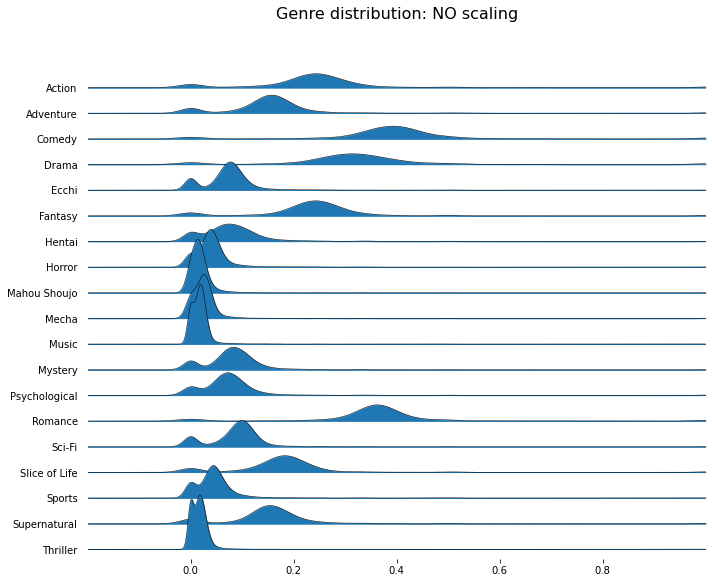

In [46]:
# Load again
df_user_genre_dist = pd.read_csv("../assets/ryota_user_genre_dist.csv")

# # Visualize the genre distribution before scaling
# # sweetviz version
# report=sv.analyze(df_user_genre_distribution)
# report.show_notebook(w=None, h=None, scale=None, layout="vertical")

# joyplot version
df_check = df_user_genre_dist.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob"]
plot_ridge(df_check, ["genre", "genre_prob"], "genre", [-0.2, 1.0], "Genre distribution: NO scaling")

In [91]:
# Calculate user similarities: Cosine similarity
user_ids = df_user_genre_dist["user_id"]
df_similarity_mat = pd.DataFrame(cosine_similarity(df_user_genre_dist.iloc[:, 1:]))
df_similarity_mat.index = user_ids
df_similarity_mat.columns = list(user_ids)
display(df_similarity_mat)

# query a similar user
input_user_id = 1

similar_users = df_similarity_mat[input_user_id].sort_values(ascending=False).reset_index()
display(similar_users.iloc[0:6, :])
top_5_similar_user_ids = similar_users.iloc[1:6, 0]
top_1_similar_user_id = similar_users.iloc[1, 0]
print(top_5_similar_user_ids)
print(top_1_similar_user_id)

,1,2,5,6,7,8,9,10,11,12,13,17,18,19,21,22,23,25,27,28,29,30,33,34,36,37,38,39,40,42,43,44,45,46,47,48,50,51,52,54,55,56,58,59,60,61,62,63,64,66,67,69,70,71,72,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,95,98,99,100,102,103,106,107,108,109,110,112,113,114,115,117,118,119,120,121,123,124,125,126,127,129,130,...,9690,9691,9692,9693,9695,9697,9699,9703,9704,9705,9706,9707,9708,9709,9711,9712,9715,9716,9717,9718,9720,9721,9722,9723,9724,9726,9728,9729,9732,9737,9795,9797,9845,9846,9848,9852,9854,9855,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,9868,9874,9876,9878,9879,9880,9881,9882,9884,9886,9887,9888,9890,9892,9894,9895,9896,9897,9899,9900,9901,9905,9906,9907,9908,9910,9911,9913,9914,9915,9916,9917,9919,9920,9923,9925,9926,9927,9929,9930,9932,9933,9934,9936,9943,9949,9968,9971,9991,9992,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.995726,0.975361,0.760160,0.996161,0.993822,0.980299,0.988452,0.967413,0.995527,0.994035,0.992896,0.609932,0.935212,0.987478,0.993392,0.995076,0.992033,0.993740,0.993250,0.982869,0.991793,0.996845,0.990014,0.995592,0.990588,0.989708,0.982787,0.992212,0.977745,0.991233,0.993430,0.986364,0.979908,0.970247,0.993085,0.930230,0.981686,0.977224,0.997501,0.995276,0.984229,0.993750,0.983572,0.994703,0.992959,0.891421,0.995156,0.973966,0.984285,0.993178,0.996256,0.994854,0.964675,0.995048,0.962706,0.471892,0.993760,0.990923,0.993491,0.987614,0.972204,0.979619,0.989078,0.994297,0.929043,0.985755,0.983305,0.990363,0.993253,0.990691,0.813914,0.985069,0.990649,0.706155,0.990855,0.618813,0.997372,0.988858,0.988173,0.994401,0.993110,0.990700,0.986292,0.990252,0.987364,0.984444,0.946833,0.935774,0.995505,0.996944,0.995668,0.989495,0.985329,0.985412,0.991437,0.946092,0.938313,0.986034,0.980701,...,0.968382,0.850689,0.991682,0.993169,0.990868,0.963223,0.992403,0.992254,0.957144,0.996219,0.993348,0.990245,0.956237,0.992548,0.989564,0.971057,0.970068,0.610365,0.993432,0.654740,0.993484,0.993889,0.842623,0.0,0.0,0.0,0.982051,0.986147,0.738029,0.990415,0.970033,0.983191,0.946159,0.978667,0.993073,0.991320,0.966728,0.993191,0.979981,0.990300,0.737712,0.890325,0.995903,0.985870,0.995144,0.978725,0.994964,0.994719,0.988568,0.990977,0.989927,0.981646,0.823296,0.981899,0.413864,0.991005,0.993334,0.996096,0.986556,0.975302,0.991519,0.994134,0.997437,0.482602,0.769951,0.991106,0.981967,0.990007,0.986861,0.990590,0.894255,0.571649,0.988673,0.814651,0.924375,0.981402,0.994957,0.979570,0.993766,0.398344,0.557565,0.985560,0.993589,0.988133,0.986030,0.802928,0.971573,0.987539,0.800538,0.988770,0.981259,0.991973,0.976193,0.975248,0.980768,0.995192,0.987749,0.946763,0.975188,0.978823
2,0.995726,1.000000,0.976039,0.722663,0.996657,0.996658,0.989244,0.993449,0.973374,0.997456,0.994786,0.992698,0.593410,0.935155,0.987549,0.991816,0.997566,0.994164,0.994061,0.994771,0.989051,0.996575,0.997106,0.993868,0.992862,0.995738,0.994970,0.987874,0.995788,0.981572,0.993760,0.996700,0.992615,0.988827,0.962041,0.996344,0.937021,0.989823,0.983670,0.998380,0.997008,0.991710,0.997499,0.987591,0.996983,0.992940,0.890836,0.996960,0.981076,0.985800,0.996278,0.997814,0.997061,0.975893,0.993632,0.965494,0.474346,0.997055,0.994398,0.995238,0.988393,0.973688,0.988154,0.991142,0.992721,0.925454,0.992368,0.990857,0.985694,0.990925,0.997109,0.788428,0.992183,0.989899,0.713488,0.985244,0.651027,0.997006,0.993651,0.993052,0.991639,0.995821,0.991825,0.992463,0.994099,0.991528,0.989693,0.961013,0.934130,0.998149,0.998303,0.995865,0.990478,0.989101,0.990704,0.993456,0.948172,0.933790,0.984208,0.979651,...,0.963118,0.855979,0.993125,0.996410,0.995416,0.972431,0.988262,0.996608,0.961714,0.996718,0.993519,0.993142,0.966575,0.989964,0.995463,0.964477,0.975441,0.636613,0.995498,0.650006,0.992541,0.996616,0.832019,0.0,0.0,0.0,0.988549,0.990839,0.765796,0.993483,0.977312,0.98613

,user_id,1
0,1,1.000000
1,6803,0.997986
2,532,0.997888
3,5708,0.997854
4,3883,0.997828
5,1393,0.997756


1    6803
2     532
3    5708
4    3883
5    1393
Name: user_id, dtype: int64
6803


,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
409,532,0.242188,0.153646,0.380208,0.279948,0.091146,0.234375,0.092448,0.037760,0.013021,0.029948,0.019531,0.067708,0.044271,0.365885,0.091146,0.175781,0.032552,0.139323,0.010417
1071,1393,0.238522,0.169093,0.376260,0.278835,0.080627,0.231803,0.097424,0.029115,0.011198,0.029115,0.023516,0.067189,0.069429,0.363942,0.108623,0.161254,0.042553,0.133259,0.017917
2979,3883,0.236152,0.148688,0.370262,0.291545,0.086006,0.233236,0.096210,0.033528,0.017493,0.026239,0.020408,0.068513,0.065598,0.351312,0.096210,0.169096,0.036443,0.125364,0.013120
4223,5708,0.244472,0.162162,0.394349,0.289926,0.100737,0.250614,0.090909,0.034398,0.022113,0.029484,0.007371,0.068796,0.058968,0.369779,0.085995,0.191646,0.042998,0.133907,0.017199
4845,6803,0.243636,0.167273,0.394545,0.270909,0.087273,0.240000,0.109091,0.029091,0.018182,0.025455,0.023636,0.060000,0.047273,0.389091,0.089091,0.176364,0.036364,0.136364,0.018182


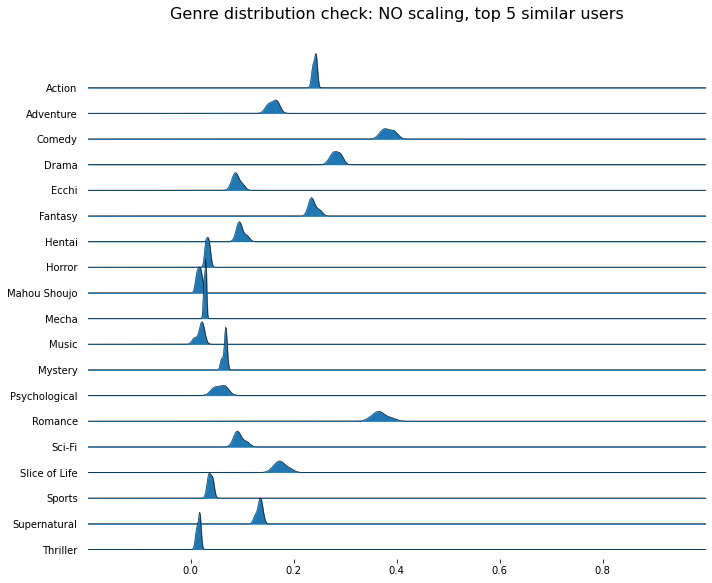

In [92]:
# Show the genre distribution of the queried user and similar users
df_check = df_user_genre_dist[df_user_genre_dist["user_id"].isin(top_5_similar_user_ids)]
display(df_check)
df_check = df_check.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob"]
plot_ridge(df_check, ["genre", "genre_prob"], "genre", [-0.2, 1.0], "Genre distribution check: NO scaling, top 5 similar users")

### Calculate user similarity by genre probability distribution: Using StandardScaler

,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
0,1,0.050389,0.219594,-0.169454,-0.303597,0.389142,0.015586,0.232277,-0.275247,0.071596,0.045606,0.393050,-0.193778,-0.300556,-0.029509,-0.075866,-0.121835,-0.139103,-0.364109,-0.278293
1,2,0.185118,0.137924,0.153614,-0.091043,0.047535,0.177673,-0.109194,-0.078537,-0.003788,0.061057,0.056607,-0.188448,-0.044391,0.240198,0.206074,0.292798,0.078272,-0.223076,0.116094
2,5,-0.023868,0.164706,-0.527193,0.003247,-0.412587,-0.501537,0.100392,-0.181152,-0.341989,0.259005,0.263466,0.145093,0.184707,-0.577338,0.405137,-0.366946,0.016499,0.165355,0.085945
3,6,-0.292776,0.394296,-1.264309,-0.798166,0.393244,-0.321571,2.532329,-0.641315,-0.395350,-0.484596,-0.513609,-1.043618,-0.848526,-2.446693,-1.169339,-0.672803,-0.764307,-1.385752,-0.538498
4,7,0.302615,0.329261,0.090129,-0.339219,0.286731,0.157433,-0.096673,0.005980,-0.134611,-0.121250,-0.133906,-0.018604,-0.058073,0.158608,0.265537,-0.018230,-0.128430,-0.102180,0.187983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,9968,0.060686,0.216937,0.068066,-0.078976,0.075040,0.047682,-0.095110,-0.125576,-0.085768,0.018717,-0.006423,-0.105492,-0.144631,-0.182587,0.298716,-0.026289,0.068407,-0.224593,0.173123
6710,9971,-0.082091,-0.499517,-0.123370,-0.457392,0.121247,-0.101474,0.179478,-0.101925,-0.013111,-0.200510,0.043030,-0.192113,-0.085965,-0.265530,0.173326,0.295284,0.156912,-0.131286,-0.282895
6711,9991,-0.512425,-0.425729,1.169995,-0.852824,1.117926,-0.059328,0.277576,-0.016490,0.401660,-0.114378,0.066717,-0.260318,-0.147046,0.143916,-0.889379,-0.088482,-0.078292,0.482603,-0.538498
6712,9992,-0.485140,-0.215051,0.450368,-0.500321,1.058563,-0.299243,0.220121,-0.428512,-0.395350,0.019759,0.276980,-0.154365,-0.529980,-0.191904,-0.787944,0.062923,-0.063379,0.014160,-0.084710


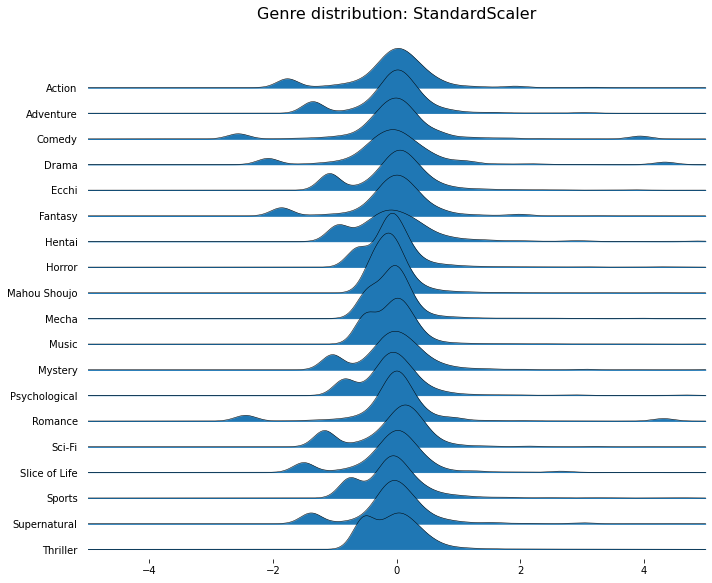

In [93]:
# Visualize the genre distribution after scaling

# Load
df_user_genre_dist_ss = pd.read_csv("../assets/ryota_user_genre_dist_ss.csv")
display(df_user_genre_dist_ss)

# # sweetviz version
# report=sv.analyze(df_user_genre_dist_ss)
# report.show_notebook(w=None, h=None, scale=None, layout="vertical")

# joyplot version
df_check = df_user_genre_dist_ss.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob_scaled"]
plot_ridge(df_check, ["genre", "genre_prob_scaled"], "genre", [-5.0, 5.0], "Genre distribution: StandardScaler")

In [94]:
# Calculate user similarities: Cosine similarity
user_ids = df_user_genre_dist_ss["user_id"]
df_similarity_mat = pd.DataFrame(cosine_similarity(df_user_genre_dist_ss.iloc[:, 1:]))
df_similarity_mat.index = user_ids
df_similarity_mat.columns = list(user_ids)
display(df_similarity_mat)

# query a similar user
input_user_id = 1

similar_users = df_similarity_mat[input_user_id].sort_values(ascending=False).reset_index()
display(similar_users.iloc[0:6, :])
top_5_similar_user_ids = similar_users.iloc[1:6, 0]
top_1_similar_user_id = similar_users.iloc[1, 0]
print(top_5_similar_user_ids)
print(top_1_similar_user_id)

,1,2,5,6,7,8,9,10,11,12,13,17,18,19,21,22,23,25,27,28,29,30,33,34,36,37,38,39,40,42,43,44,45,46,47,48,50,51,52,54,55,56,58,59,60,61,62,63,64,66,67,69,70,71,72,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,95,98,99,100,102,103,106,107,108,109,110,112,113,114,115,117,118,119,120,121,123,124,125,126,127,129,130,...,9690,9691,9692,9693,9695,9697,9699,9703,9704,9705,9706,9707,9708,9709,9711,9712,9715,9716,9717,9718,9720,9721,9722,9723,9724,9726,9728,9729,9732,9737,9795,9797,9845,9846,9848,9852,9854,9855,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,9868,9874,9876,9878,9879,9880,9881,9882,9884,9886,9887,9888,9890,9892,9894,9895,9896,9897,9899,9900,9901,9905,9906,9907,9908,9910,9911,9913,9914,9915,9916,9917,9919,9920,9923,9925,9926,9927,9929,9930,9932,9933,9934,9936,9943,9949,9968,9971,9991,9992,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.171542,-0.015214,0.558918,0.246715,0.052974,-0.513265,-0.415976,-0.427157,0.302393,0.326682,0.472750,-0.058622,-0.120508,0.021997,0.534599,0.468874,-0.114507,0.020906,0.333237,-0.539016,0.079304,0.606119,-0.086387,0.599912,-0.196161,-0.430623,0.103304,-0.025857,-0.109313,-0.266358,0.357490,-0.336603,-0.543171,0.439057,-0.303237,-0.245283,-0.363026,-0.518895,0.585769,0.399778,-0.299327,0.213591,-0.202156,0.142469,0.404985,0.387312,0.426598,-0.304242,-0.388396,0.266837,0.523113,0.392861,-0.370203,0.626929,-0.363803,0.184285,0.051438,0.046984,-0.005444,0.069562,0.314513,-0.470079,0.250566,0.689525,0.055762,-0.224297,-0.596052,0.741500,0.579360,-0.320518,0.427256,-0.118243,0.428984,-0.065396,0.630836,-0.252853,0.708857,-0.326527,-0.005408,0.625494,-0.061053,-0.133252,-0.349706,-0.365699,0.267039,-0.356833,-0.629457,-0.141443,0.295680,0.524188,0.498367,-0.082862,0.086549,0.174094,0.154569,0.249485,0.310580,0.577020,0.139706,...,0.211630,-0.242540,0.045569,0.392804,-0.347157,-0.455831,0.450579,-0.357712,-0.128689,0.401374,0.104330,0.431437,0.029484,0.549679,-0.424198,0.186579,-0.628316,-0.161408,0.260444,0.029784,0.519723,0.332114,0.524155,0.246716,0.246716,0.246716,-0.461217,-0.200186,-0.486576,0.116695,-0.390279,0.194991,0.317156,-0.359514,0.231518,0.318365,-0.157164,0.191179,-0.265753,0.509240,0.049248,-0.243537,0.397826,-0.322313,0.454462,-0.365481,0.208131,0.328565,0.243201,-0.365650,0.387828,-0.292928,-0.041569,-0.530361,-0.151277,-0.393526,-0.076503,0.681085,-0.032950,0.451732,0.052676,0.311597,0.759386,0.069110,0.337960,0.340630,-0.441737,-0.247462,0.301377,0.041039,0.025534,0.058471,0.029999,0.378975,-0.044611,-0.464328,0.568232,-0.103636,0.593916,0.349654,-0.076682,-0.367185,0.584910,-0.272619,0.202710,-0.059163,0.127773,0.523120,-0.027457,-0.211313,0.654314,0.006468,0.074765,-0.446874,0.324884,0.294301,0.304132,0.277495,0.510141,-0.397143
2,0.171542,1.000000,-0.412465,-0.333275,0.583586,0.675698,0.367133,0.292585,0.233301,0.645387,-0.254768,0.275691,-0.720127,-0.337968,0.312705,-0.183602,0.113555,0.344021,0.386908,0.358532,0.109827,0.581639,0.027691,0.341292,-0.110913,0.425419,0.395748,-0.234794,0.111186,-0.187999,0.303512,0.256205,0.261999,0.164533,-0.367525,0.513850,0.097000,0.402497,0.114092,0.437153,0.092633,0.297568,0.338536,-0.226983,0.101204,-0.339339,-0.104131,0.527346,0.341346,-0.031770,-0.006286,0.478541,0.479314,0.030227,-0.159342,-0.087042,-0.048781,0.329043,0.348320,0.234795,0.092911,-0.275577,0.356099,0.194875,-0.015538,-0.256571,0.238584,0.244584,-0.100033,-0.154010,0.617980,-0.426173,0.332402,-0.192273,0.113532,-0.233528,0.147995,0.056897,0.333432,0.472751,-0.157240,0.558514,-0.083643,0.210517,0.074974,0.040197,-0.174192,0.094479,0.209561,0.426702,0.362002,-0.111034,0.152341,0.245160,0.688904,-0.144418,0.167864,-0.326713,-0.085887,-0.638220,...,0.006253,-0.378187,0.223133,0.358224,0.474569,0.095526,-0.162129,0.102366,0.124791,0.548604,-0.036773,0.111086,0.107218,0.409098,0.351504,0

,user_id,1
0,1,1.000000
1,7828,0.841799
2,6155,0.829862
3,1550,0.814047
4,8980,0.802448
5,6830,0.800950


1    7828
2    6155
3    1550
4    8980
5    6830
Name: user_id, dtype: int64
7828


,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
1198,1550,-0.164533,0.016174,-0.010603,-0.237712,0.177092,-0.067981,0.051347,-0.230910,-0.017265,0.001746,0.248745,-0.167068,-0.131797,0.084693,0.158732,-0.057688,-0.163512,-0.254005,-0.198157
4487,6155,-0.010891,0.219594,-0.079417,-0.250226,0.266078,-0.261822,0.264535,-0.193899,-0.239701,-0.050795,0.317495,-0.465727,-0.361441,-0.160674,-0.112315,-0.144888,-0.094445,-0.364109,-0.104823
4864,6830,-0.187434,-0.013548,-0.259968,-0.587488,0.479432,-0.333799,0.178597,-0.214021,-0.147602,-0.024272,0.135803,-0.459252,-0.296126,-0.030848,-0.229473,-0.095977,-0.295167,-0.410056,-0.289995
5498,7828,-0.097680,-0.139907,-0.188633,-0.441053,0.340119,-0.186848,0.448685,-0.279169,0.066594,0.061600,0.220256,-0.300713,-0.207862,0.131653,-0.018741,-0.236170,-0.113670,-0.420994,-0.257679
6263,8980,-0.155586,0.027625,0.005595,-0.200744,0.152172,0.144216,0.067832,-0.231546,0.214455,0.000992,0.374425,-0.358686,-0.235139,0.007356,0.054672,0.004581,-0.164443,-0.160459,-0.247230


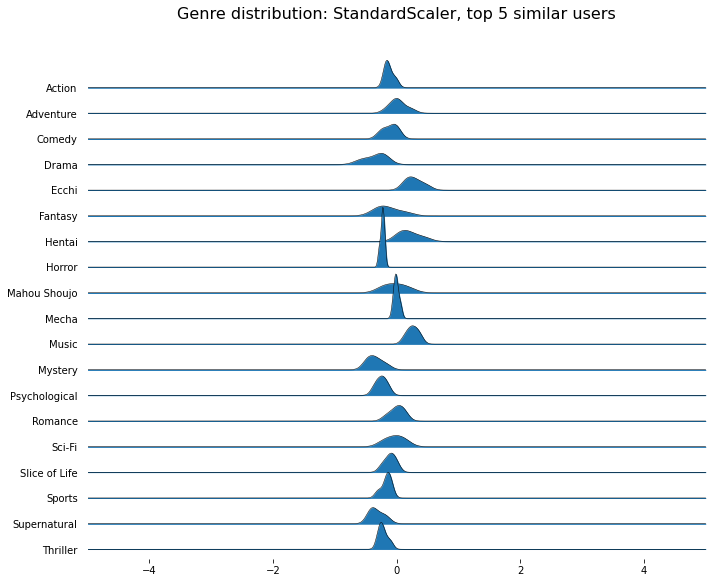

,user_id,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Hentai,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
1198,1550,0.217391,0.156832,0.392857,0.287267,0.085404,0.232919,0.086957,0.027950,0.020186,0.027950,0.027950,0.071429,0.065217,0.374224,0.100932,0.173913,0.037267,0.128882,0.010870
4487,6155,0.238227,0.180055,0.382271,0.285319,0.091413,0.207756,0.105263,0.030471,0.008310,0.024931,0.030471,0.047091,0.044321,0.337950,0.080332,0.163435,0.041551,0.116343,0.013850
4864,6830,0.214286,0.153439,0.354497,0.232804,0.105820,0.198413,0.097884,0.029101,0.013228,0.026455,0.023810,0.047619,0.050265,0.357143,0.071429,0.169312,0.029101,0.111111,0.007937
5498,7828,0.226457,0.139013,0.365471,0.255605,0.096413,0.217489,0.121076,0.024664,0.024664,0.031390,0.026906,0.060538,0.058296,0.381166,0.087444,0.152466,0.040359,0.109865,0.008969
6263,8980,0.218605,0.158140,0.395349,0.293023,0.083721,0.260465,0.088372,0.027907,0.032558,0.027907,0.032558,0.055814,0.055814,0.362791,0.093023,0.181395,0.037209,0.139535,0.009302


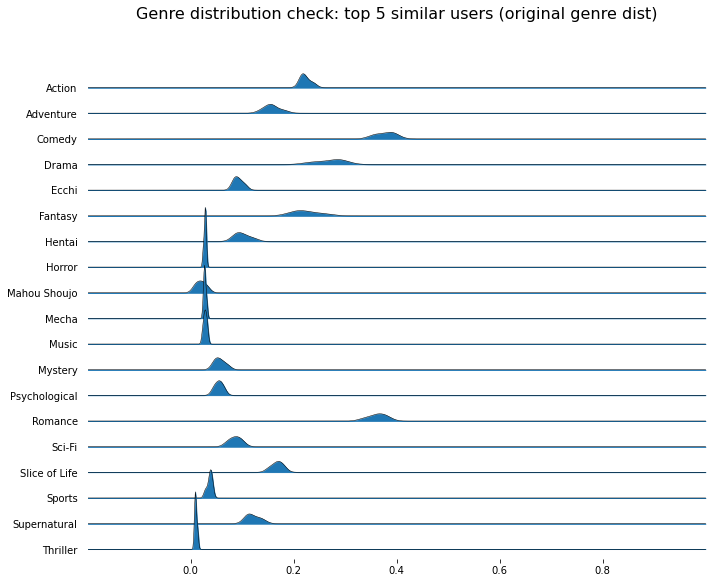

In [95]:
# Show the genre distribution of the queried user and similar users
df_check = df_user_genre_dist_ss[df_user_genre_dist_ss["user_id"].isin(top_5_similar_user_ids)]
display(df_check)
df_check = df_check.set_index("user_id").stack().reset_index()
df_check.columns = ["user_id", "genre", "genre_prob_scaled"]
plot_ridge(df_check, ["genre", "genre_prob_scaled"], "genre", [-5.0, 5.0], "Genre distribution: StandardScaler, top 5 similar users")

# Check with original genre probability
df_check_titles = df_user_genre_dist[df_user_genre_dist["user_id"].isin(top_5_similar_user_ids)]
display(df_check_titles)
df_check_titles = df_check_titles.set_index("user_id").stack().reset_index()
df_check_titles.columns = ["user_id", "genre", "genre_prob"]
plot_ridge(df_check_titles, ["genre", "genre_prob"], "genre", [-0.2, 1.0], "Genre distribution check: top 5 similar users (original genre dist)")

### Interpretation:
- Better to go without scaling?
- Looks fairly similar in terms of the genre distribution but some are "wider" distribution
- Also, cosine similarity scores are mostly abo 0.9 without scaling, whereas 0.8 with scaling

### Developing an similarity evaluation metric: Checking similarities by looking at overlapping titles in media_list

In [ ]:
# get the id-romaji match for each title
id_romaji_match = df_titles[["title_id", "title_romaji"]]

# Get the titles that the queried user and the most similar user has read/watched
df_mlist = pd.read_csv("../assets/media_list_all_users.csv")
df_mlist_romaji = pd.merge(id_romaji_match, df_mlist, how="inner", on="title_id")

# Work out the overlapping and non-overlapping titles
df_sim = df_mlist_romaji[df_mlist_romaji["user_id"]==top_1_similar_user_id]
df_q = df_mlist_romaji[df_mlist_romaji["user_id"]==1]
sim_u_list = list(df_sim["title_id"])
q_u_list = list(df_q["title_id"])
overlap = list(set(sim_u_list) & set(q_u_list))
non_overlap = list(set(sim_u_list) ^ set(q_u_list))
print("for user_id: ", top_1_similar_user_id)
print("overlapping titles: ", len(overlap))
print("non-overlapping titles: ", len(non_overlap))

In [ ]:
# If the user is looking for something new:
# Within those "non-overlapping" titles, 
# which one matches the user genre distribution the most?

df_titles_genre = pd.read_csv("../assets/ryota_title_genre_2000p.csv")
df_non_overlap = df_titles_genre[df_titles_genre["title_id"].isin(non_overlap)]
print(len(df_non_overlap["title_id"].unique()))
print(len(df_non_overlap))

# If the user might not be looking for something new:
a = df_user_genre_distribution.loc[lambda x : x.user_id==1].iloc[:, 1:].values
b = df_non_overlap.iloc[:, 1:].values - a
display(df_user_genre_distribution.loc[lambda x : x.user_id==1])
display(df_non_overlap.iloc[:, 1:])
print(b)
print(b.shape)
b = b.sum(axis=1)
print(b.shape)

c = pd.concat([df_non_overlap["title_id"].reset_index(), pd.DataFrame(b)], axis=1)
c[0].unique()

# Choose the one that's closest to zero



### Use other metrics to get the similar users

In [16]:
# Calculate user similarities: Euclidean
# Calculate user similarities: Manhattan


## Tags

In [3]:
df_media_list_tags = pd.read_csv("../assets/ryota_media_list_tags.csv")
display(df_media_list_tags)

,user_id,mlist_count,4-koma,Abuse,Achromatic,Achronological Order,Acting,Adoption,Advertisement,Afterlife,Age Gap,Age Regression,Agender,Agriculture,Ahegao,Airsoft,Aliens,Alternate Universe,American Football,Amnesia,Amputation,Anachronism,Anal Sex,Angels,Animals,Anthology,Anti-Hero,Archery,Armpits,Artificial Intelligence,Asexual,Ashikoki,Asphyxiation,Assassins,Astronomy,Athletics,Augmented Reality,Autobiographical,Aviation,Badminton,Band,Bar,Baseball,Basketball,Battle Royale,Biographical,Bisexual,Blackmail,Body Horror,Body Swapping,Bondage,Boobjob,Boxing,Boys Love,Bullying,Butler,CGI,Calligraphy,Cannibalism,Card Battle,Cars,Centaur,Cheerleading,Chibi,Chimera,Chuunibyou,Circus,Classic Literature,Clone,College,Coming of Age,Conspiracy,Cosmic Horror,Cosplay,Crime,Crossdressing,Crossover,Cult,Cultivation,Cumflation,Cunnilingus,Cute Boys Doing Cute Things,Cute Girls Doing Cute Things,Cyberpunk,Cyborg,Cycling,DILF,Dancing,Death Game,Deepthroat,Defloration,Delinquents,Demons,Denpa,Detective,Dinosaurs,Disability,Dissociative Identities,Dragons,Drawing,...,Primarily Male Cast,Primarily Teen Cast,Prostitution,Public Sex,Puppetry,Rakugo,Rape,Real Robot,Rehabilitation,Reincarnation,Religion,Revenge,Robots,Rotoscoping,Rugby,Rural,Sadism,Samurai,Satire,Scat,School,School Club,Scissoring,Scuba Diving,Seinen,Sex Toys,Shapeshifting,Ships,Shogi,Shoujo,Shounen,Shrine Maiden,Skateboarding,Skeleton,Slapstick,Slavery,Software Development,Space,Space Opera,Steampunk,Stop Motion,Succubus,Suicide,Sumata,Sumo,Super Power,Super Robot,Superhero,Surfing,Surreal Comedy,Survival,Sweat,Swimming,Swordplay,Table Tennis,Tanks,Tanned Skin,Teacher,Teens Love,Tennis,Tentacles,Terrorism,Threesome,Time Manipulation,Time Skip,Tokusatsu,Tomboy,Torture,Tragedy,Trains,Transgender,Travel,Triads,Tsundere,Twins,Urban,Urban Fantasy,VTuber,Vampire,Video Games,Vikings,Villainess,Virginity,Virtual World,Volleyball,Vore,Voyeur,War,Watersports,Werewolf,Witch,Work,Wrestling,Writing,Wuxia,Yakuza,Yandere,Youkai,Yuri,Zombie
0,1,398,0,0,0,30,8,10,0,14,22,11,8,5,0,3,31,35,0,45,0,10,0,5,18,2,55,7,0,24,4,0,0,14,3,4,3,1,6,1,12,6,9,2,13,3,19,0,42,10,0,0,4,2,30,3,60,0,11,1,3,1,0,10,2,18,1,4,0,8,90,22,31,7,34,32,1,14,7,0,0,4,39,13,10,2,0,2,16,0,0,11,34,28,14,1,16,30,15,13,...,0,0,0,0,0,0,0,0,4,1,0,2,3,0,0,0,0,2,3,0,18,4,0,0,8,0,0,0,0,0,10,0,0,0,2,0,0,6,1,0,0,0,1,0,0,15,3,6,0,9,6,0,1,1,0,1,0,0,0,0,0,1,0,6,0,1,1,0,5,0,0,0,0,2,1,0,9,0,4,3,0,0,0,5,0,0,0,2,0,0,1,6,0,1,0,0,0,3,2,2
1,2,303,0,0,0,12,3,10,0,10,11,8,3,2,0,0,30,25,0,32,0,4,0,4,7,0,32,7,0,10,2,0,0,9,1,2,3,0,4,1,14,4,12,3,10,1,7,0,29,14,0,0,3,2,28,7,42,0,9,3,0,0,1,11,4,11,3,3,1,9,63,15,18,6,23,25,4,6,9,0,0,4,23,5,7,1,0,1,11,0,0,12,25,13,12,5,16,24,10,7,...,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,2,0,17,6,0,0,4,0,0,0,0,1,18,0,0,0,1,0,0,1,0,0,0,0,1,0,0,14,2,4,0,4,4,0,1,2,0,0,0,1,0,0,0,1,0,4,0,0,0,0,6,0,0,0,0,2,0,0,5,0,4,1,0,0,0,2,1,1,0,1,0,0,1,3,0,3,0,0,0,2,1,5
2,5,323,2,0,0,2,7,5,0,8,17,3,2,1,0,0,19,8,0,21,0,8,0,3,4,1,16,1,0,8,0,0,0,13,0,3,1,0,3,0,4,2,8,4,3,0,4,0,15,5,0,0,4,2,30,2,13,0,2,1,0,0,0,10,3,2,3,0,2,12,41,13,2,1,18,20,0,4,5,0,0,2,2,3,3,0,0,0,3,0,0,15,24,2,3,0,7,13,11,1,...,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,39,2,0,0,13,0,0,0,0,53,31,0,0,0,1,0,0,8,0,0,0,0,1,0,0,8,2,1,0,0,0,0,1,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,4,0,0,2,0,4,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,1,0,2,0,1
3,6,9,2,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,0,0,0,1,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,409,1,0,1,16,4,4,2,8,16,4,1,2,3,1,32,22,1,35,0,8,2,7,13,3,28,5,0,27,3,0,0,5,2,3,5,0,7,1,7,5,10,2,12,4,11,0,19,12,1,2,3,5,37,12,43,0,5,5,4,0,0,19,2,20,3,6,0,10,69,19,17,8,28,42,2,7,1,0,1,6,30,5,7,1,0,3,10,0,0,13,16,24,10,1,10,15,8,9,...,0,1,0,0,0,0,0,0,0,0,0,0,5,

In [4]:
# # zip 3 values
# zip_values = zip(df_media_list_tags["user_id"], df_media_list_tags["mlist_count"], df_media_list_tags.iloc[:, 2:].values)

# # for each user, calculate the probability of a chosen title belonging to a certain tag
# res = []
# for u_id, mlist_count, tag_values in zip_values:
#     tag_probability = tag_values / mlist_count
#     row = np.insert(tag_probability, 0, u_id)
#     res.append(row)

# tag_cols = list(df_media_list_tags.iloc[:, 2:].columns)
# df_user_tags_dist = pd.DataFrame(res, columns=["user_id"]+tag_cols)
# df_user_tags_dist["user_id"] = df_user_tags_dist["user_id"].astype(int)
# display(df_user_tags_dist)

# # Save the files to csv
# df_user_tags_dist.to_csv("../assets/ryota_user_tags_dist.csv", index=False)

### Use PCA/Truncated SVD to reduce dimension

In [3]:
# Load data
df_user_tags_dist = pd.read_csv("../assets/ryota_user_tags_dist.csv")

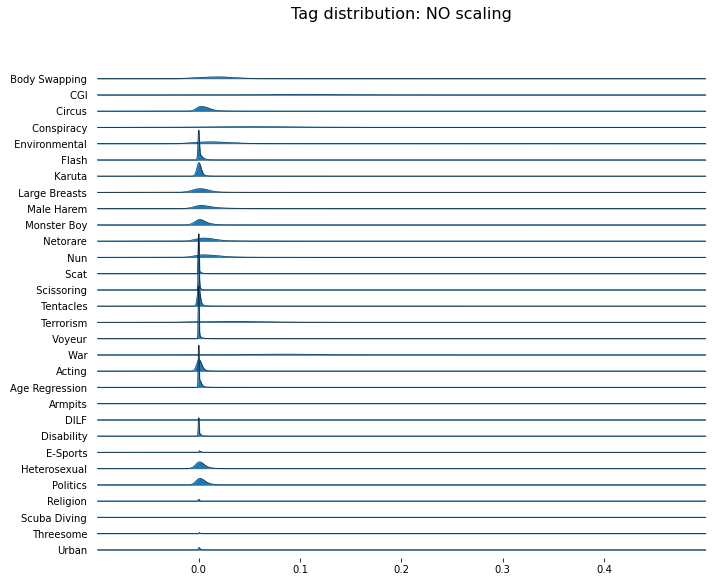

In [11]:
# Visuzalize tag probability distribution

# Limit the data to 30 tags that are picked at random
df_user_tags_dist_col_sampled = df_user_tags_dist.set_index("user_id")
df_user_tags_dist_col_sampled = df_user_tags_dist_col_sampled.sample(30, axis=1)
df_check = df_user_tags_dist_col_sampled.stack().reset_index()
df_check.columns = ["user_id", "tag", "tag_prob"]
plot_ridge(df_check, ["tag", "tag_prob"], "tag", [-0.1, 0.5], "Tag distribution: NO scaling")

In [15]:
# First, SS then PCA

# Scale tag probability distribution with StandardScaler()
ss = StandardScaler()
df_user_tags_dist_val = df_user_tags_dist.iloc[:, 1:]
df_user_tags_dist_ss = pd.DataFrame(ss.fit_transform(df_user_tags_dist_val), columns=df_user_tags_dist_val.columns)

# PCA: keep 90% variance explanation -> 333 features
# PCA: keep 80% variance explanation -> 250 features
# It just doesn't work well
pca = PCA(n_components=0.9, random_state=42)
pca.fit(df_user_tags_dist_ss)
print(sum(pca.explained_variance_ratio_))
print(len(pca.explained_variance_ratio_))

# Try 20 components
pca = PCA(n_components=20, random_state=42)
pca.fit(df_user_tags_dist_ss)
print(sum(pca.explained_variance_ratio_))
print(len(pca.explained_variance_ratio_))

0.9000718564173058
333
0.2531873102778895
20


In [13]:
# Check how sparse each column is
df_sparse_ratio = df_user_tags_dist[df_user_tags_dist == 0].count(axis=0)/len(df_user_tags_dist.index)

# Columns with +90% zeros
print(list(df_sparse_ratio[df_sparse_ratio > 0.9].index))

[' Abuse', ' Armpits', ' Ashikoki', ' Asphyxiation', ' Blackmail', ' Cumflation', ' Deepthroat', ' Exhibitionism', ' Flat Chest', ' Ice Skating', ' MILF', ' Netorase', ' Netori', ' Non-fiction', ' Omegaverse', ' Puppetry', ' Reformation', ' Rimjob', ' Scat', ' Scissoring', ' Squirting', ' Stop Motion', ' Sumata', ' Sumo', ' Sweat', ' Teens Love', ' Vikings', ' Virginity', 'Achromatic', 'Adoption', 'Agender', 'Agriculture', 'Ahegao', 'Amputation', 'Anachronism', 'Anal Sex', 'Archery', 'Armpits', 'Asexual', 'Ashikoki', 'Autobiographical', 'Badminton', 'Biographical', 'Bisexual', 'Blackmail', 'Body Horror', 'Bondage', 'Boobjob', 'Cannibalism', 'Centaur', 'Cheerleading', 'Chimera', 'Circus', 'Clone', 'College', 'Cultivation', 'Cumflation', 'Cunnilingus', 'Cyborg', 'DILF', 'Deepthroat', 'Defloration', 'Dinosaurs', 'Disability', 'Drugs', 'Dullahan', 'E-Sports', 'Elf', 'Ero Guro', 'Exhibitionism', 'Facial', 'Fashion', 'Feet', 'Fellatio', 'Femdom', 'Fencing', 'Fitness', 'Flash', 'Flat Chest', 

In [14]:
# Calculate similarity directly
user_ids = df_user_tags_dist["user_id"]
df_similarity_mat = pd.DataFrame(cosine_similarity(df_user_tags_dist.iloc[:, 1:]))
df_similarity_mat.index = user_ids
df_similarity_mat.columns = list(user_ids)
display(df_similarity_mat)

# query a similar user
input_user_id = 1

similar_users = df_similarity_mat[input_user_id].sort_values(ascending=False).reset_index()
display(similar_users.iloc[0:6, :])
top_5_similar_user_ids = similar_users.iloc[1:6, 0]
top_1_similar_user_id = similar_users.iloc[1, 0]
print(top_5_similar_user_ids)
print(top_1_similar_user_id)

,1,2,5,6,7,8,9,10,11,12,13,17,18,19,21,22,23,25,27,28,29,30,33,34,36,37,38,39,40,42,43,44,45,46,47,48,50,51,52,54,55,56,58,59,60,61,62,63,64,66,67,69,70,71,72,74,75,76,77,78,79,80,82,83,84,85,86,87,88,90,91,92,93,95,98,99,100,102,103,106,107,108,109,110,112,113,114,115,117,118,119,120,121,123,124,125,126,127,129,130,...,9690,9691,9692,9693,9695,9697,9699,9703,9704,9705,9706,9707,9708,9709,9711,9712,9715,9716,9717,9718,9720,9721,9722,9723,9724,9726,9728,9729,9732,9737,9795,9797,9845,9846,9848,9852,9854,9855,9857,9858,9859,9860,9861,9862,9863,9864,9865,9866,9867,9868,9874,9876,9878,9879,9880,9881,9882,9884,9886,9887,9888,9890,9892,9894,9895,9896,9897,9899,9900,9901,9905,9906,9907,9908,9910,9911,9913,9914,9915,9916,9917,9919,9920,9923,9925,9926,9927,9929,9930,9932,9933,9934,9936,9943,9949,9968,9971,9991,9992,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.983246,0.892253,0.662266,0.971426,0.953932,0.963058,0.982468,0.960851,0.982471,0.935624,0.961651,0.433185,0.933980,0.924726,0.969887,0.972618,0.973503,0.939676,0.941917,0.835895,0.887127,0.979713,0.855890,0.962095,0.931637,0.970839,0.838106,0.978046,0.831020,0.977968,0.983353,0.979407,0.930393,0.668897,0.940743,0.910656,0.956999,0.935501,0.965426,0.957344,0.903209,0.987143,0.914379,0.950682,0.965118,0.803215,0.979278,0.953208,0.967198,0.979370,0.978681,0.952712,0.940668,0.945202,0.855888,0.250334,0.987182,0.980948,0.978855,0.921774,0.952548,0.975132,0.912205,0.943488,0.846542,0.964509,0.959990,0.968021,0.981750,0.976617,0.710139,0.954881,0.971709,0.506671,0.839126,0.469539,0.976741,0.949460,0.960969,0.952759,0.976895,0.982972,0.969592,0.981719,0.927994,0.943302,0.882526,0.889530,0.937458,0.987891,0.975801,0.962160,0.933624,0.931586,0.975182,0.881031,0.808554,0.931173,0.849557,...,0.900237,0.542752,0.957382,0.967360,0.966536,0.910325,0.968118,0.892365,0.751519,0.954877,0.843552,0.953216,0.820179,0.923014,0.868015,0.877752,0.871345,0.472522,0.933569,0.690855,0.972846,0.971547,0.731730,0.489026,0.489026,0.489026,0.972026,0.945905,0.296861,0.927653,0.925719,0.918890,0.872480,0.949654,0.928634,0.962134,0.946772,0.930322,0.957404,0.970684,0.544206,0.798494,0.955245,0.967333,0.989314,0.953917,0.960725,0.974557,0.971798,0.970047,0.873929,0.966200,0.700845,0.976766,0.498367,0.976953,0.978400,0.981123,0.945431,0.913274,0.929346,0.971216,0.980647,0.509966,0.757173,0.968789,0.970518,0.963448,0.912761,0.983316,0.710573,0.340918,0.892038,0.891231,0.815254,0.942850,0.974988,0.970235,0.987220,0.381158,0.372792,0.905121,0.974104,0.895900,0.971962,0.602491,0.901368,0.954463,0.601896,0.974502,0.939895,0.965419,0.908499,0.904751,0.889186,0.980892,0.938937,0.889922,0.913095,0.896896
2,0.983246,1.000000,0.894394,0.655859,0.971829,0.969960,0.954113,0.985010,0.955132,0.976368,0.942182,0.963384,0.427714,0.921115,0.937159,0.959526,0.977399,0.966722,0.943938,0.942116,0.845320,0.896845,0.976672,0.866213,0.956307,0.946440,0.970209,0.824921,0.971570,0.865114,0.967254,0.978491,0.973545,0.935121,0.669720,0.940546,0.909534,0.935695,0.936277,0.973567,0.954258,0.882009,0.980012,0.914120,0.952704,0.963951,0.818656,0.971040,0.947285,0.972952,0.966207,0.972179,0.953964,0.935264,0.956989,0.855150,0.226694,0.979876,0.973143,0.976994,0.908586,0.954362,0.966498,0.926567,0.944740,0.848301,0.961702,0.959245,0.967572,0.981488,0.979593,0.703328,0.956359,0.963641,0.560321,0.823517,0.499301,0.975981,0.960311,0.957054,0.945963,0.967545,0.980346,0.960523,0.981468,0.926094,0.952851,0.869770,0.901920,0.944734,0.983922,0.978524,0.955722,0.945081,0.941255,0.963863,0.899744,0.802209,0.941287,0.855136,...,0.915231,0.543036,0.962828,0.966415,0.966229,0.901186,0.969502,0.906161,0.767565,0.963037,0.867515,0.949018,0.847205,0.924917,0.888361,0.899892,0.884488,0.494289,0.927547,0.714210,0.969195,0.966061,0.763142,0.514085,0.514085,0.514085,0.969300,0.961737,0.31

,user_id,1
0,1,1.000000
1,438,0.992332
2,1550,0.989496
3,9863,0.989314
4,1751,0.989031
5,3445,0.988692


1     438
2    1550
3    9863
4    1751
5    3445
Name: user_id, dtype: int64
438
